## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import gymnasium as gym
from diffuser.utils.config import Config, get_params, get_device_settings
from justin_arm.training_justin import Justin_Trainer
from justin_arm.helper import (
    create_state_action_array,
    interpolate_trajectories,
    condition_start_end_per_trajectory,
)
from rokin import robots, vis
from diffuser.utils.arrays import report_parameters, batchify
from diffuser.datasets.sequence import TrajectoryDataset
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import wandb
from tqdm import tqdm

# Render original and diffused trajectories:
from justin_arm.visualize import (
    plot_trajectory_per_frames,
    plot_q_values_per_trajectory,
)
from justin_arm.helper import robot_env_dist, analyze_distance

## Parse Arguments and Paramters

In [ ]:
# Get settings from the config file

parser = get_params()

# overwrite params for Justin Arm
args = args = parser.parse_args(
    [
        "--action_dim",
        "7",
        "--observation_dim",
        "7",
        "--train_batch_size",
        "1",
        "--savepath",
        "saved_justin/",
        "--dataset",
        "new_dataset",
        "--horizon",
        "32",
        "--save_freq",
        "1000",
        "--train_lr",
        "0.01",
    ]
)

# Set Seeds
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Get device settings
device = get_device_settings(args)

# Check if saved path exists else create it :
if not os.path.exists(args.savepath):
    os.makedirs(args.savepath)

In [ ]:
dataset = np.load("justin_arm/data/q_paths_4123.npy")
dataset_image = np.load("justin_arm/data/image_4123.npy")
trajectory_dataset = TrajectoryDataset(
    dataset=dataset, horizon=args.horizon, image=dataset_image
)
robot = robots.JustinArm07()


model_config = Config(
    args.model,
    savepath=(args.savepath, "model_config.pkl"),
    horizon=args.horizon,
    transition_dim=args.observation_dim + args.action_dim,
    cond_dim=args.observation_dim,
    dim_mults=args.dim_mults,
    device=device,
)
diffusion_config = Config(
    _class="models.diffuser.GaussianDiffusion",
    savepath=(args.savepath, "diffusion_config.pkl"),
    horizon=args.horizon,
    observation_dim=args.observation_dim,
    action_dim=args.action_dim,
    n_timesteps=args.n_timesteps,
    loss_type=args.loss_type,
    clip_denoised=args.clip_denoised,
    predict_epsilon=args.predict_epsilon,
    # loss weighting
    action_weight=args.action_weight,
    loss_weights=args.loss_weights,
    loss_discount=args.loss_discount,
    device=device,
)

trainer_config = Config(
    Justin_Trainer,
    savepath=(args.savepath, "trainer_config.pkl"),
    train_batch_size=args.train_batch_size,
    train_lr=args.train_lr,
    name=args.env_name,
    gradient_accumulate_every=args.gradient_accumulate_every,
    ema_decay=args.ema_decay,
    sample_freq=args.sample_freq,
    save_freq=args.save_freq,
    label_freq=args.label_freq,
    save_parallel=args.save_parallel,
    results_folder=args.savepath,
    bucket=args.bucket,
    n_reference=args.n_reference,
    n_samples=args.n_samples,
    device=device,
)

In [ ]:
# Print min and max:

print(trajectory_dataset.normalizer.maxs)

print("Min: ", np.min(trajectory_dataset.normalized_data))
print("Max: ", np.max(trajectory_dataset.normalized_data))
# Print mean and std:
print("Mean: ", np.mean(trajectory_dataset.normalized_data))
print("Std: ", np.std(trajectory_dataset.normalized_data))

In [ ]:
# Load objects

model = model_config()
diffuser = diffusion_config(model)
trainer = trainer_config(diffuser, trajectory_dataset, device, robot)

## Forward pass is working

In [ ]:
report_parameters(model)

print("Testing forward...", end=" ", flush=True)
batch = batchify(trajectory_dataset[0])
loss, _ = diffuser.loss(*batch)
loss.backward()
print("✓")

## Using the trainer requires taking care of the 'device' in the folders

# Training process inlcluding rendering

In [ ]:
current_time = datetime.now().strftime("%d_%m_%Y-%H-%M")

if args.use_wandb:
    run = wandb.init(
        config=args,
        project=args.wandb_project,
        entity=args.wandb_entity,
        name=f"Run_{current_time}",
        group="Group-Name",
        job_type="training",
        reinit=True,
    )

## Training

In [ ]:
# n_epochs = int(args.n_train_steps // args.n_steps_per_epoch)
n_epochs = 1
diffuser.to(device)
for i in tqdm(range(n_epochs)):
    print(f"Epoch {i} / {n_epochs} | {args.savepath}")
    trainer.train(n_train_steps=10)

## Training for a single datapoint : 1. Experiment!

In [20]:
# Overfit to a single datapoint

from diffuser.utils.arrays import apply_dict, batch_to_device, to_device, to_np

# Choose a single trajectory through the dataloader given a batch size of 1, then we do not know exactly what idx that is
# single_input = next(iter(trainer.dataloader))
# single_input = batch_to_device(single_input, device)

# Choose a single trajectory arbitrarily
single_input = batchify(trajectory_dataset[10])
single_input = batch_to_device(single_input, device)

# Just sample the trajectory directly from the dataset:
single_input_unnormalized = interpolate_trajectories(dataset[10], 32)

# # Start training
# diffuser.to(device)
# n_epochs = 500  # Overfitting typically requires fewer epochs
# for i in tqdm(range(n_epochs)):
#     print(f"Epoch {i} / {n_epochs} | {args.savepath}")
#     trainer.train_single_datapoint(n_train_steps=20, single_input=single_input)

## Loading existing model and visualize performance:

In [19]:
# Load and test the model on the single datapoint:
model_path = "saved_justin_one_trajecotry//state_10000.pt"
trainer.load(directory=model_path, epoch=500)

### Plot the trajectory taken directly from the dataset:

In [ ]:
# # Plor the orginal trajectory
# %matplotlib inline

# # Plot the original and diffused trajectories:
# # Original:

# # Get collision_metric:
# distance = robot_env_dist(
#     q=single_input_unnormalized[0], robot=trainer.robot, img=trainer.dataset.image[0]
# )

# score = analyze_distance(distance)

# print(f"Collision score: {score}")


# print(single_input_unnormalized[0].shape)

# plot_trajectory_per_frames(single_input_unnormalized[0])
# plot_q_values_per_trajectory(single_input_unnormalized[0])


# limits = np.array([[-1.25, +1.25], [-1.25, +1.25], [-1.25, +1.25]])
# vis.three_pv.animate_path(
#     robot=trainer.robot,
#     q=single_input_unnormalized[0],
#     kwargs_robot=dict(color="red"),
#     kwargs_world=dict(img=trainer.dataset.image[0], limits=limits, color="yellow"),
# )

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "/Users/magic-rabbit/miniforge3/envs/new_diffuser/lib/python3.10/site-packages/wslink/protocol.py", line 317, in onCompleteMessage
    await self.sendWrappedMessage(
  File "/Users/magic-rabbit/miniforge3/envs/new_diffuser/lib/python3.10/site-packages/wslink/protocol.py", line 418, in sendWrappedMessage
    await ws.send_bytes(chunk)
  File "/Users/magic-rabbit/miniforge3/envs/new_diffuser/lib/python3.10/site-packages/aiohttp/web_ws.py", line 342, in send_bytes
    await self._writer.send(data, binary=True, compress=compress)
  File "/Users/magic-rabbit/miniforge3/envs/new_diffuser/lib/python3.10/site-packages/aiohttp/http_websocket.py", line 727, in send
    await self._send_frame(message, WSMsgType.BINARY, compress)
  File "/Users/magic-rabbit/miniforge3/envs/new_diffuser/lib/python3.10/site-packages/aiohttp/http_websocket.py", line 679, in _send_frame
    self._write(

### Plotting the reference trajectory:

In [ ]:
%matplotlib inline

# Plot the original and diffused trajectories:
# Original:
trajectory = single_input.trajectories.numpy()

## [ n_samples x horizon x observation_dim ]
normed_observations = trajectory[:, :, : trainer.dataset.action_dim[0]]

## [ n_samples x (horizon + 1) x observation_dim ]
observations = trainer.dataset.normalizer.unnormalize(normed_observations[0])
# print(f"After unnormalizing: {observations.shape}")

# Get collision_metric:
distance = robot_env_dist(
    q=observations, robot=trainer.robot, img=trainer.dataset.image[0]
)

score = analyze_distance(distance)

print(f"Collision score: {score}")


print(observations.shape)


plot_trajectory_per_frames(observations)
plot_q_values_per_trajectory(observations)


limits = np.array([[-1.25, +1.25], [-1.25, +1.25], [-1.25, +1.25]])
vis.three_pv.animate_path(
    robot=trainer.robot,
    q=observations,
    kwargs_robot=dict(color="red"),
    kwargs_world=dict(img=trainer.dataset.image[0], limits=limits, color="yellow"),
)

### Plotting the diffused reconstruction:

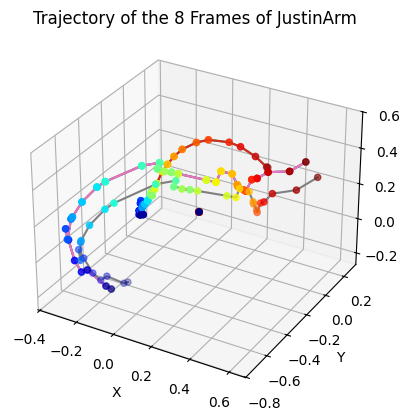

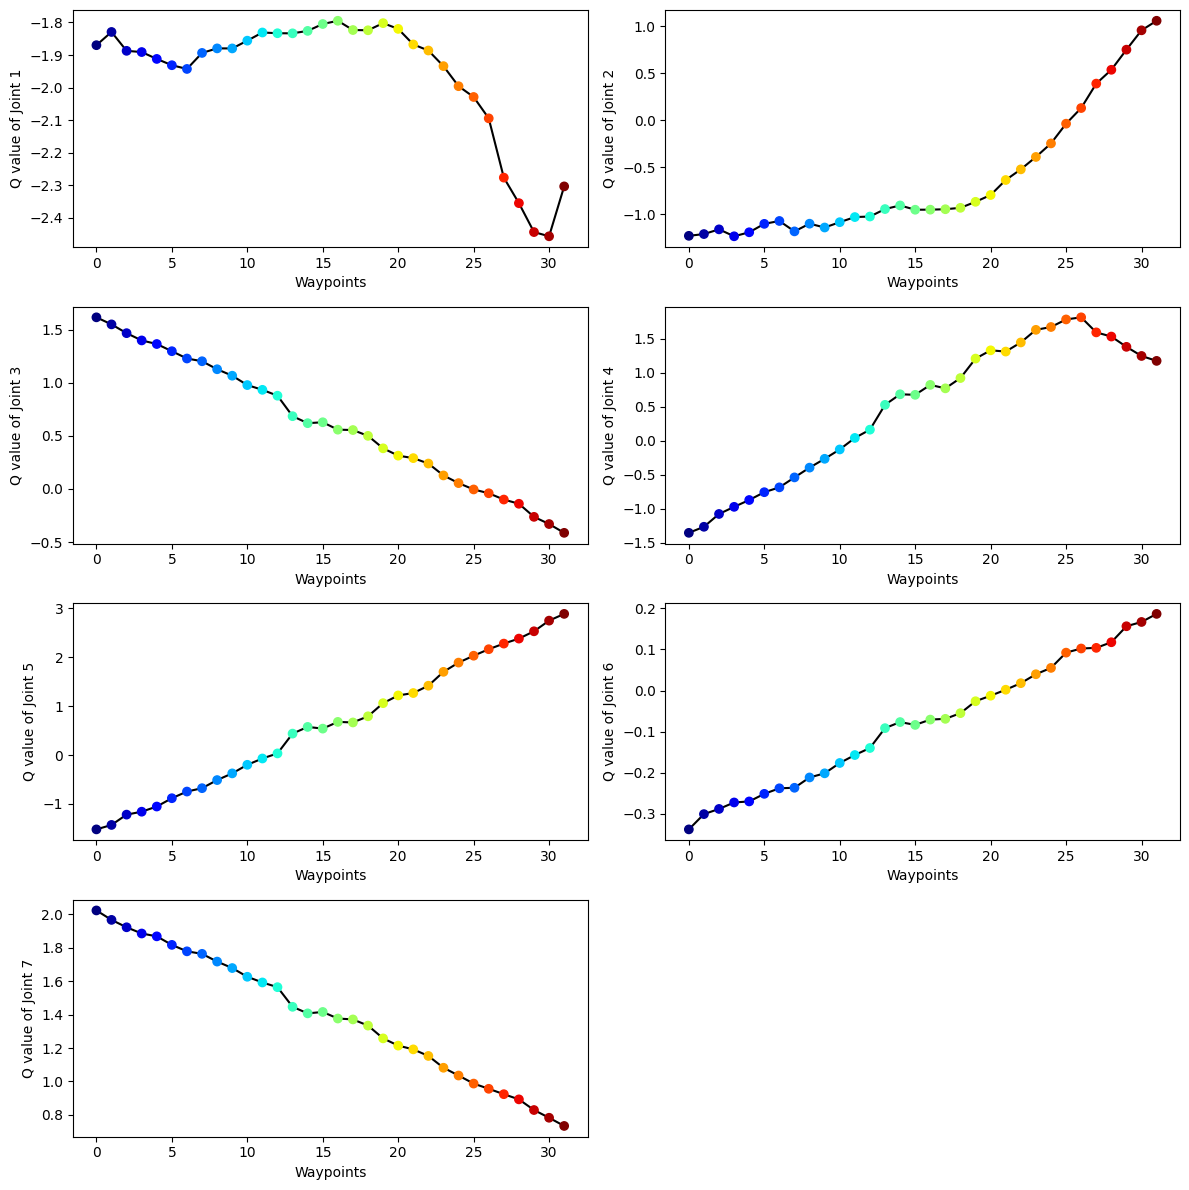

Widget(value='<iframe src="http://localhost:64193/index.html?ui=P_0x29b19a890_6&reconnect=auto" class="pyvista…

Collision score: 0


In [23]:
# Now plotting for the diffused trajectory:
%matplotlib inline

collision_score = trainer.render_given_sample(single_input, render_3d=True)
print(f"Collision score: {collision_score}")